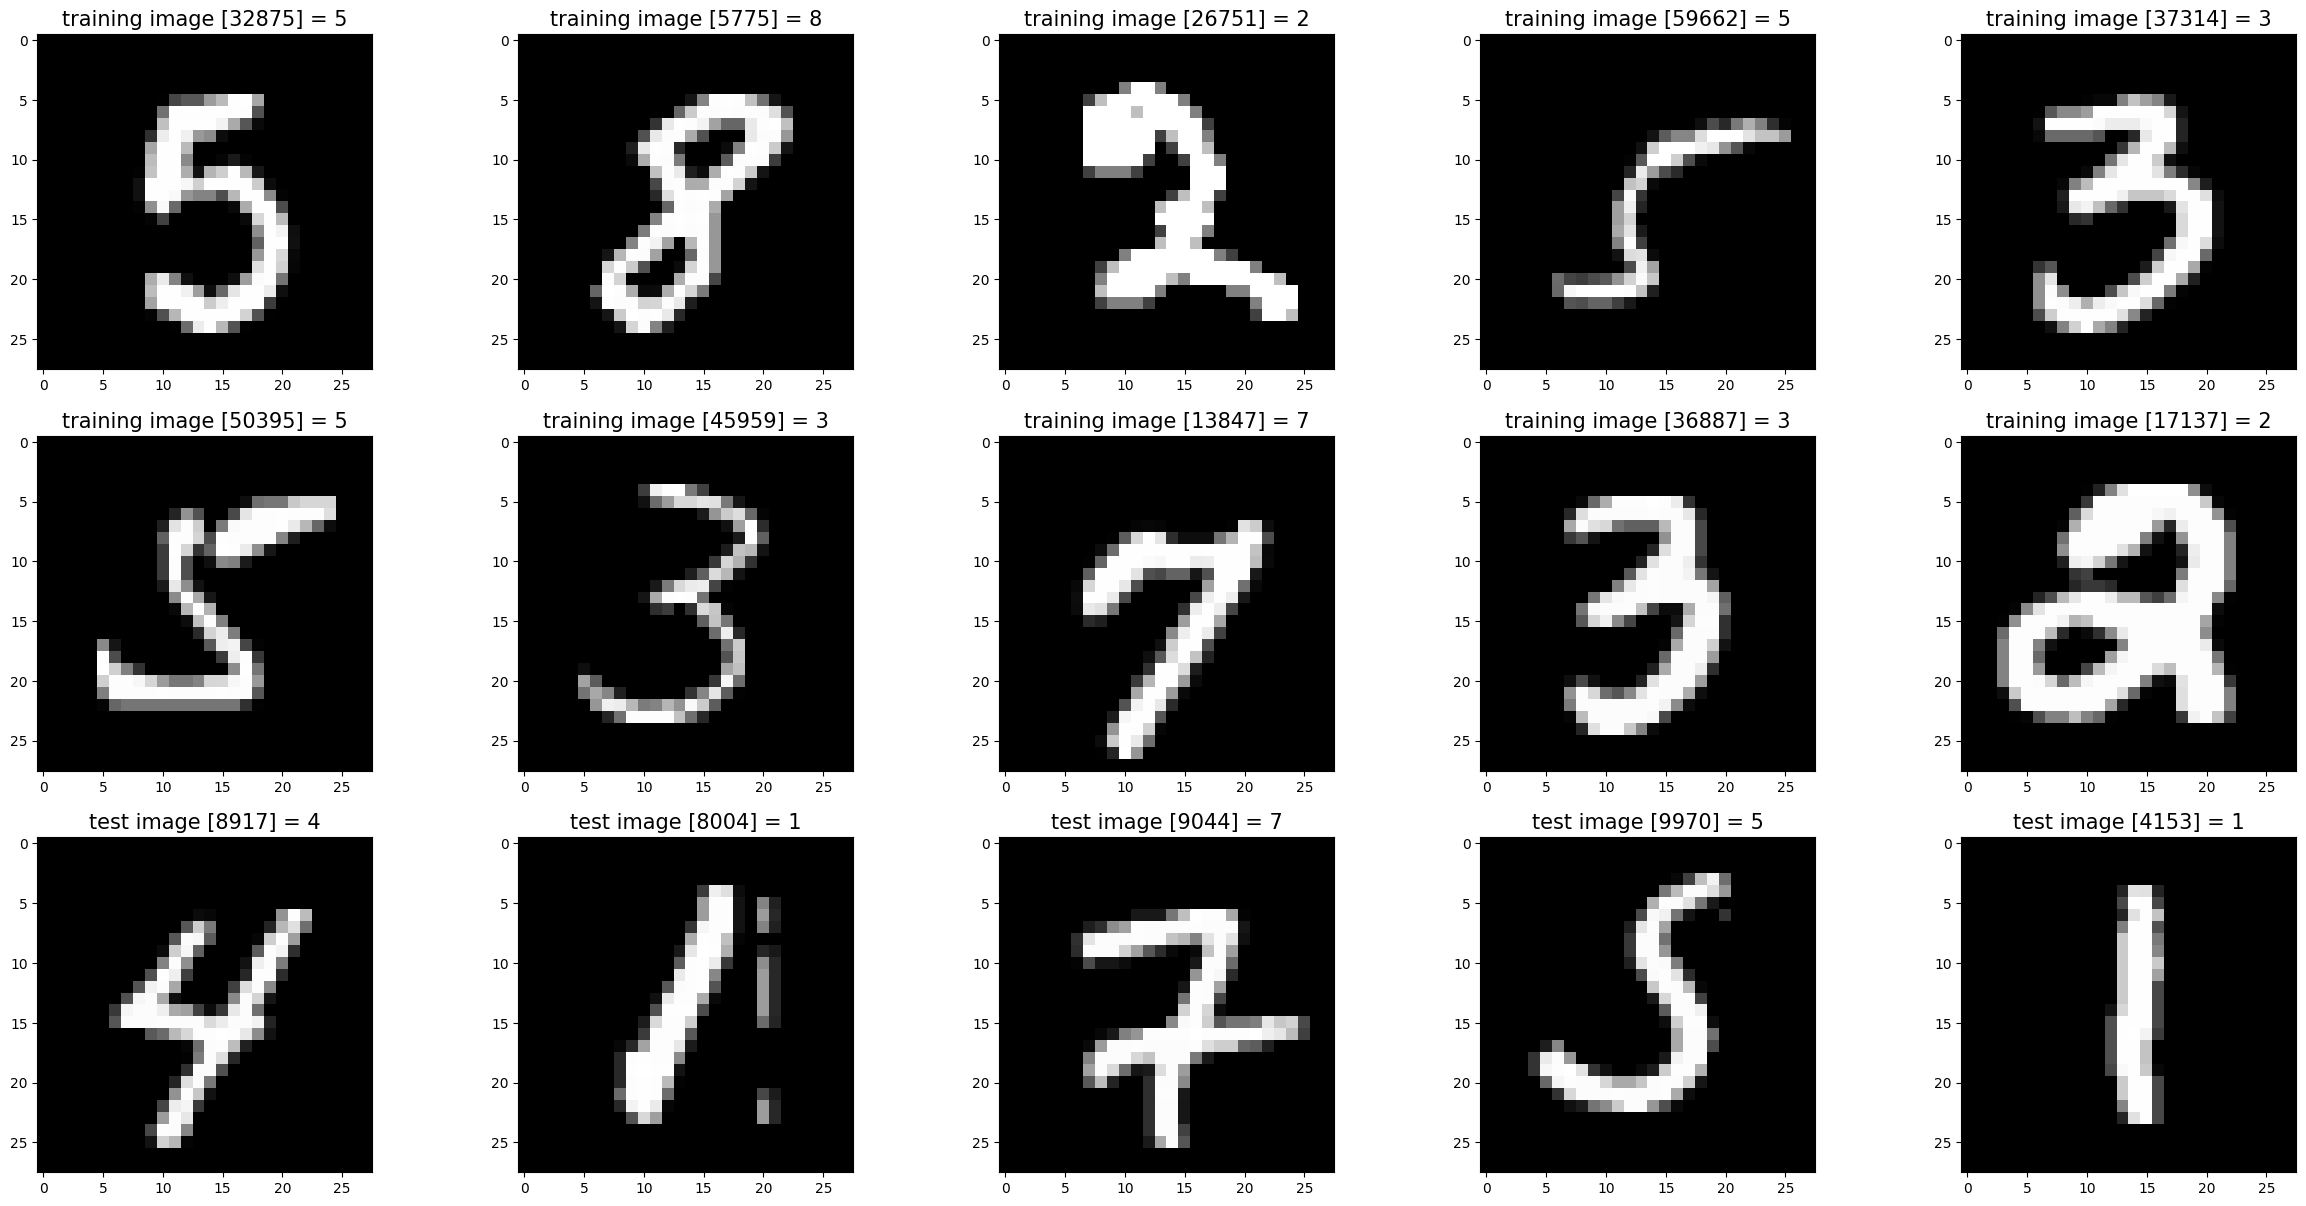

In [1]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
from data.mnist import load_data, transform_data
from os.path  import join
base_path = './data/datasets'

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

x_train_display, y_train_display, x_test_display, y_test_display = load_data(base_path)

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train_display[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train_display[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test_display[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test_display[r]))    

show_images(images_2_show, titles_2_show)
x_train, y_train, x_test, y_test = transform_data(x_train_display, y_train_display, x_test_display, y_test_display)

In [2]:
# Figure out the appropriate dimensions for the MLP layer here!

# maybe look into the data?

first_layer = 784 # TODO: Replace 42 with the appropriate value! 
last_layer = 10 # TODO: Replace 42 with the appropriate value!

layers = [first_layer, 250, 100, last_layer]

In [3]:
from nn.linear import init_parameters
from nn.functions import linear
import numpy.random as rnd

# init parameters 
random_state = rnd.RandomState(42)
parameters = init_parameters(layers, random_state=random_state)

# check if your shapes look correct
for layer in parameters:
    A, b = layer
    print("A", A.shape, "b", b.shape)


A (784, 250) b (250,)
A (250, 100) b (100,)
A (100, 10) b (10,)


In [4]:
# do a dummy linear transformation
x = x_train[1]# an image in the training set
y = linear(x, parameters[0][0], parameters[0][1])
print(y.shape) # this should be the same shape as the input for our second layer

(250,)


In [5]:
import jax.numpy as jnp
from act.functions import relu

# Now implement your model that makes the prediction on x!
#  - it should take the parameters we initialized above and the input x
#  - add a non-linear activations function e.g. relu after each linear transformation
# return the output of the last layer

def model(parameters, x):
    for A, b in parameters:
        x = linear(x, A, b)
        x = relu(x)
    return x

y = model(parameters, x)
print(y.shape) # this should be the same shape as the last layer
print(y) # that will be our prediction, or will it? 



(10,)
[0.         0.         0.         0.06530478 0.         2.498077
 0.77026653 0.89603007 0.         0.        ]


In [6]:
# calculate the celoss
from loss.functions import celoss
Y = y.reshape(1, -1) # we reshape because our CELoss function expects a 2D array (N, 10)
Y_TRAIN = y_train[1].reshape(1, -1) # we reshape because our CELoss function expects a 2D array (N, 10)

print(celoss(Y, Y_TRAIN)) # this should be a scalar value

3.1712294


In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
# training


from jax import jit, grad, value_and_grad
from jax.debug import print as dprint
from tqdm.notebook import tqdm
learning_rate = 0.001
epochs = 20
batch_size = 32

# re-init parameters, why not!
random_state = rnd.RandomState(42)
parameters = init_parameters(layers, random_state=random_state)

avg_loss = AverageMeter()
avg_acc = AverageMeter()

def accuracy(params, x_batch, y_batch):
  preds = model(params, x_batch)
  target_class = jnp.argmax(y_batch, axis=1)
  predicted_class = jnp.argmax(preds, axis=1)
  return jnp.mean(predicted_class == target_class)
  
def forward(parameters, x_batch, y_batch):
    preds = model(parameters, x_batch)
    loss = celoss(preds, y_batch)
    return loss

@jit
def forward_backward(parameters, x_batch, y_batch):
    loss, gradients = value_and_grad(forward, (0))(parameters, x_batch, y_batch) 
    return loss, [[A - learning_rate * dA, b - learning_rate * db] for (A, b), (dA, db) in zip(parameters, gradients)]

for epoch in range(epochs):

    bar_train = tqdm(range(0, len(x_train), batch_size))
    for i in bar_train:
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        # forward pass
        loss, parameters = forward_backward(parameters, x_batch, y_batch)
        avg_loss.update(loss, batch_size)
        bar_train.set_description(f"TRAIN LOSS:{avg_loss.avg}")

    bar_test = tqdm(range(0, len(x_test), batch_size))
    for i in bar_test:
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        # forward pass
        acc = accuracy(parameters, x_batch, y_batch)
        avg_acc.update(acc, batch_size)
        bar_test.set_description(f"TEST ACC:{avg_acc.avg}")




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

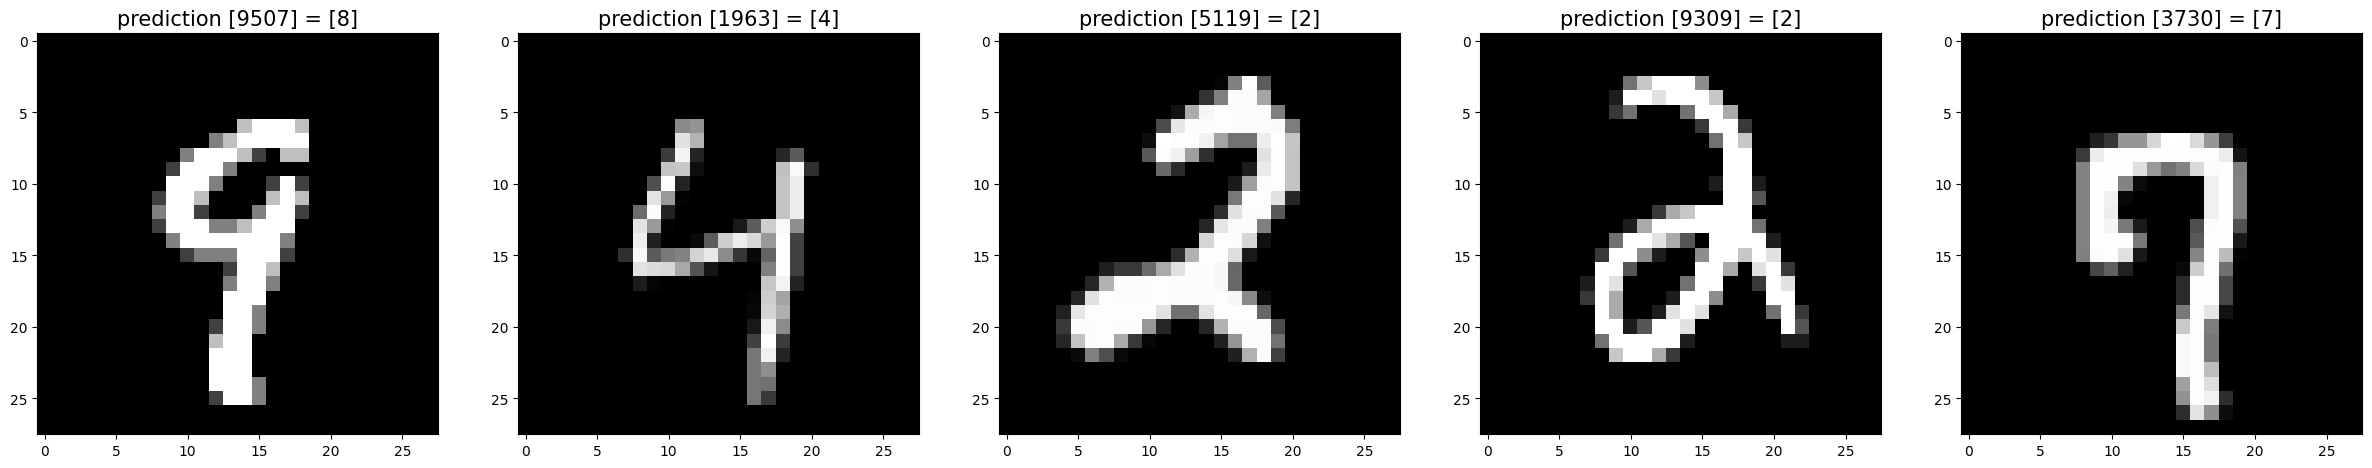

In [19]:
# visualize the prediction

def predict(params, x_batch):
    preds = model(params, x_batch)
    target_class = jnp.argmax(preds, axis=1)
    return target_class

images_2_show = []
titles_2_show = []



for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test_display[r])        
    titles_2_show.append('prediction [' + str(r) + '] = ' + str(predict(parameters, x_test[r].reshape(1, -1))))    

show_images(images_2_show, titles_2_show)